In [1]:
import os
import collections
from tqdm import tqdm
import statistics
import copy
import math
import numpy as np
import csv
import matplotlib.pyplot as plt

In [2]:
rows = []

anime_id_to_name = {}
anime_name_to_id = {}
anime_id_to_genres = {}

with open('anime.csv', newline='') as f:
    file_rows = csv.reader(f)
    first_row = True
    for row in file_rows:
        if first_row:
            first_row = False
        else:
            anime_id = int(row[0])
            anime_name = row[1]
            anime_genres = set()
            anime_genres_spaces = row[2].split(',')
            for genre in anime_genres_spaces:
                if not genre:
                    continue
                if genre[0] == ' ':
                    anime_genres.add(genre[1:])
                else:
                    anime_genres.add(genre)
                
            
            
            anime_id_to_name[anime_id] = anime_name
            anime_name_to_id[anime_name] = anime_id
            anime_id_to_genres[anime_id] = anime_genres   
            
anime_names = anime_name_to_id.keys()
anime_ids = anime_id_to_name.keys()

In [3]:
print(anime_id_to_name[list(anime_id_to_genres.keys())[618]],list(anime_id_to_genres.items())[618])

Zan Sayonara Zetsubou Sensei Bangaichi (7044, {'School', 'Comedy', 'Parody'})


In [4]:
all_genres_counter = collections.Counter([genre for anime_genres in anime_id_to_genres.values() for genre in anime_genres])

all_genres = set()
for s in anime_id_to_genres.values():
    all_genres |= s
    
anime_count = len(list(anime_ids))

In [5]:
def acalculate_tfidf(anime):
    terms = list(anime_id_to_genres[anime])
    terms_len = len(terms)
    
    tfidfd = collections.defaultdict(lambda: 0.0)

    for genre in anime_id_to_genres[anime]:
        tfidfd[genre] = 1.0/terms_len * np.log10(anime_count/all_genres_counter[genre])

    ksum = sum(tfidfd[k] for k in tfidfd.keys())
    for k in tfidfd.keys():
        tfidfd[k] = tfidfd[k]/ksum
        
    return tfidfd

acalculate_tfidf(7044)

defaultdict(<function __main__.acalculate_tfidf.<locals>.<lambda>()>,
            {'School': 0.34537275392030353,
             'Comedy': 0.145506621494283,
             'Parody': 0.5091206245854135})

In [6]:
def acalculate_cosine(anime1, anime2):
        
    # this is done so that a title is similar to itself even if it doesnt have any tags
    if anime1 == anime2:
        return 1
    
    anime1tfidf = acalculate_tfidf(anime1)
    anime2tfidf = acalculate_tfidf(anime2)
    
    licznik = 0.0
    for k in set(list(anime1tfidf.keys()) + list(anime2tfidf.keys())):
        licznik += anime1tfidf[k] * anime2tfidf[k]
    
    m1 = sum(anime1tfidf[k]**2.0 for k in anime1tfidf.keys())
    m2 = sum(anime2tfidf[k]**2.0 for k in anime2tfidf.keys())
    
    try:
        res = licznik/(math.sqrt(m1) * math.sqrt(m2))
        if not math.isnan(res):
            return res
        else:
            return -1
    except:
        return -1

In [7]:
# idk if it makes sens to have this function, 
# we could maybe merge functions i.e calculate_cosine from here and danbooru notebook
def acalculate_series_similarity(series1, series2):
    return acalculate_cosine(series1, series2)

In [8]:
ratings = collections.defaultdict(lambda: {})
user_ids = set()

with open('rating.csv','r') as f:
    lines = f.read().splitlines()
    lines = lines[1:]
    for line in lines:
        line = line.split(',')
        user_id = int(line[0])
        anime_id = int(line[1])
        if anime_id not in anime_ids:
            continue
        rating = int(line[2])
        ratings[user_id][anime_id] = rating
        user_ids.add(user_id)

In [9]:
def knn(user_id, anime_id, K):
    result = []
    
    for other_anime_id in ratings[user_id].keys():
        if other_anime_id != anime_id and ratings[user_id][other_anime_id] != -1:
            result.append((acalculate_series_similarity(anime_id,other_anime_id),other_anime_id,ratings[user_id][other_anime_id]))
        
    result = sorted(result, reverse=True)
    
    K = min(K, len(result))
    
    return result[0:K]

In [10]:
def get_rating(user_id,anime_id,K):
    neighbors = knn(user_id,anime_id,K)
    
    if not neighbors:
        return 5
    
    rating = 0
    for neighbor in neighbors:
        rating += neighbor[2]
        
    return rating / len(neighbors)

In [11]:
def get_tests(path):
    tests = []
    with open(path,'r') as f:
        lines = f.read().splitlines()
        for line in lines:
            line = line.split(' ')
            user_id = int(line[0])
            anime_id = int(line[1])
            if anime_id not in anime_ids:
                continue

            tests.append((user_id,anime_id))
    return tests

In [12]:
def tester(test_user_ids,K):
    mse = 0
    n = 0
    for test in tests:
        user_id = test[0]
        tested_anime_id = test[1]
        rating = ratings[user_id][tested_anime_id]
        predicted_rating = get_rating(user_id,tested_anime_id,K)
        n += 1
        mse += (rating - predicted_rating)**2
    
    return mse / n

100%|██████████| 200/200 [00:10<00:00, 19.21it/s]


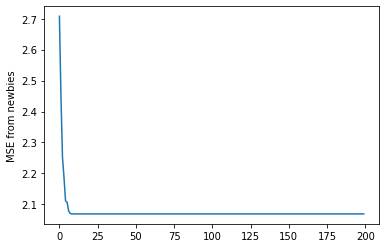

In [13]:
#paths = ['connoisseur.txt','newbies.txt','popular.txt','random.txt']
paths = ['newbies.txt']
for path in paths:
    res = []
    for k in tqdm(range(200)):
        tests = get_tests(path)
        mse = tester(tests,k+1) 
        res.append(mse)
    path_wo_ext = path.split('.')[0]
    plt.plot(res)
    plt.ylabel(f'MSE from {path_wo_ext}')
    plt.show()

In [14]:
tagname2tagid = {}
tagid2tagname = {}
idfocccounter = collections.defaultdict(lambda: 0)

In [15]:
def load_anime():
    charactercount = 0
    characterstat = collections.defaultdict(lambda: 0.0)
    characters = collections.defaultdict(lambda: copy.deepcopy(characterstat))
    animes = collections.defaultdict(lambda: copy.deepcopy(characters))
    
    for anime in tqdm(list(os.listdir("BIG_animedump"))):
        for character in list(os.listdir(f"BIG_animedump/{anime}")):
            with open(f"BIG_animedump/{anime}/{character}", "r") as f:
                data = f.read().split("\n")
                for l in data[1:-1]:
                    tagc, tagid, tagname = l.split()
                    tagc = int(tagc[:-1])
                    tagid = int(tagid[:-1])
                    animes[anime][character[:-4]][tagid] = tagc
                    tagname2tagid[tagname] = tagid
                    tagid2tagname[tagid] = tagname
                    idfocccounter[tagid] += 1
                    charactercount += 1
                    
    return (charactercount, animes)

In [16]:
charactercount, animedata = load_anime()

100%|██████████| 18265/18265 [00:05<00:00, 3178.60it/s]


In [17]:
def calculate_tfidf(character):
    terms = sum(character[k] for k in character.keys())
    tfidfd = collections.defaultdict(lambda: 0.0)

    for k in character.keys():
        tfidfd[k] = character[k]/terms * np.log10(charactercount/idfocccounter[k])

    ksum = sum(tfidfd[k] for k in tfidfd.keys())
    for k in tfidfd.keys():
        tfidfd[k] = tfidfd[k]/ksum
        
    return tfidfd

In [18]:
def calculate_cosine(character1, character2):
    char1tfidf = calculate_tfidf(character1)
    char2tfidf = calculate_tfidf(character2)
    
    licznik = 0.0
    for k in set(list(char1tfidf.keys()) + list(char2tfidf.keys())):
        licznik += char1tfidf[k] * char2tfidf[k]
    
    m1 = sum(char1tfidf[k]**2.0 for k in char1tfidf.keys())
    m2 = sum(char2tfidf[k]**2.0 for k in char2tfidf.keys())

    if math.isnan(licznik/(math.sqrt(m1) * math.sqrt(m2))):
        return -1.0
    return licznik/(math.sqrt(m1) * math.sqrt(m2))

In [19]:
def calculate_series_similarity(series1, series2):
    atmp = []
    #print(len(animedata[series1].keys()), len(animedata[series2].keys()))
    t1 = list(animedata[series1].keys())
    t2 = list(animedata[series2].keys())
    
    f1 = []
    f2 = []
    sizeconst = 64
    if len(t1) < sizeconst:
        f1 = t1
    else:
        ind = np.random.choice(len(t1), sizeconst, replace=False)
        for i in ind:
            f1.append(t1[i])

    if len(t2) < sizeconst:
        f2 = t2
    else:
        ind = np.random.choice(len(t2), sizeconst, replace=False)
        for i in ind:
            f2.append(t2[i])

    for charactera in f1:
        for characterb in f2: 
            atmp.append(( 
                calculate_cosine(
                    animedata[series1][charactera], 
                    animedata[series2][characterb]
                ), charactera, characterb)
            )
    
    resmap = [q[0] for q in atmp]
    return (min(resmap), max(resmap), statistics.mean(resmap))
    
print(calculate_series_similarity("nekopara", "kobayashi-san_chi_no_maidragon"))
print(calculate_series_similarity("nekopara", "asobi_ni_iku_yo!"))

(0.0, 0.4710330441368347, 0.23593691467242672)
(0.17370068582234513, 0.630942176413259, 0.37067900425897216)


In [20]:
def load_animedict():
    id2booruname = collections.defaultdict(lambda: (None, None))
    with open("conversion_dictionary.csv", "r") as f:
        for a in f.read().split("\n")[1:]:
            try:
                malid, boorun, confidence = a.split(",")
                id2booruname[int(malid)] = (boorun[1:], float(confidence))
            except Exception as e:
                print(f"thrown {e}")
                print(f"for {a}")
                
    return id2booruname
            
id2boorunamed = load_animedict()

thrown not enough values to unpack (expected 3, got 1)
for 


In [21]:
print(id2boorunamed[38924])
print(id2boorunamed[6166])

def idbased_seriesdistance(id1, id2):
    anime1, confidence1 = id2boorunamed[id1]
    anime2, confidence2 = id2boorunamed[id2]
    if anime1 and anime2:
        return (calculate_series_similarity(anime1, anime2), (confidence1, confidence2))
    else:
        return ((100000000, 100000000, 100000000), (0.0, 0.0))
    
idbased_seriesdistance(38924, 6166)

('nekopara', 0.009940357852882704)
('asobi_ni_iku_yo!', 0.02054340622929092)


((0.17370068582234513, 0.630942176413259, 0.37067900425897216),
 (0.009940357852882704, 0.02054340622929092))

In [22]:
def load_marks():
    userrating = collections.defaultdict(lambda: [])
    with open("rating.csv", "r") as f:
        for t in f.read().split("\n")[1:]:
            try:
                userid, animeid, mark = t.split(",")
                userrating[int(userid)].append((int(animeid), int(mark)))
            except Exception as e:
                print(f"thrown {e}")
                print(f"for {t}")
    return userrating


In [23]:
user_ratings = load_marks()

thrown not enough values to unpack (expected 3, got 1)
for 


In [24]:
memcache = {}

In [51]:
def calculate_score(target_id, rratings, id2boorunamed):
    ratings = []
    for r in rratings:
        if r[1] == -1:
            pass
        else:
            ratings.append(r)
    
    if len(ratings) == 1:
        return False, [5.0 for _ in range(200)]
    
    targetname, target_conf = id2boorunamed[target_id]
    
    if targetname == None:
        return False, [5.0 for _ in range(200)]

    distmapv = []
    for serieid, serierating in ratings:
        if serieid != target_id:
            seriename, serieconf = id2boorunamed[serieid]
            if seriename:
                try:
                    if (targetname, seriename) in memcache:
                        seriesim = memcache[(targetname, seriename)]
                    else:
                        seriesim = calculate_series_similarity(targetname, seriename)
                        memcache[(targetname, seriename)] = seriesim
                    distmapv.append((seriesim[2], serierating))
                except Exception as e:
                    distmapv.append((0.0, serierating))
    #print(distmapv)
    q = sorted(distmapv, reverse=True)
    
    finscores = []
    licznik = 0.0
    mianownik = 0.0001
    
    if len(q) == 0:
        return False, [5.0 for _ in range(200)]
    
    dudes = []
    #for sd, ss in q:
    #    dudes.append(ss)
    #    finscores.append(sum(dudes)/len(dudes))
    
    for sd, ss in q:
        licznik += sd*ss
        mianownik += sd
        finscores.append(licznik/mianownik)
    
    keep = finscores[-1]
    while len(finscores) < 200:
        finscores.append(keep)
    
    return True, finscores

def calculate_mse(target, target_rating, scoring):
    ts = 0
    for aid, sc in target_rating:
        if aid == target:
            ts = sc
    if ts == -1:
        raise NotImplemented
    return [(s-ts)**2 for s in scoring]

def runtest(target, id2boorunamed):
    oks = 0
    fails = 0
    My_mse = []
    Awg_mse = []
    Joined_mse = []
    T_mse = []
    with open(target, "r") as f:
        testdata = f.read().split("\n")[:-1]
        for t in tqdm(testdata):
            userid, animeid = t.split(" ")
            sure, scores = calculate_score(int(animeid), user_ratings[int(userid)], id2boorunamed)
            Tscores = [get_rating(int(userid), int(animeid), k+1) for k in range(200)]            
            # Wyłącznie Moje
            MyScores = copy.deepcopy(scores)
            # Zawsze średnia
            Awg = [(scores[i] + Tscores[i])/2.0 for i in range(200)]
            # Tomkowe gdy ja nie umiem.
            Joined = []
            if sure:
                Joined = copy.deepcopy(scores)
            else:
                Joined = copy.deepcopy(Tscores)
            
            My_mse.append(calculate_mse(int(animeid), user_ratings[int(userid)], MyScores))
            Awg_mse.append(calculate_mse(int(animeid), user_ratings[int(userid)], Awg))
            Joined_mse.append(calculate_mse(int(animeid), user_ratings[int(userid)], Joined))
            T_mse.append(calculate_mse(int(animeid), user_ratings[int(userid)], Tscores))

    return My_mse, Awg_mse, Joined_mse, T_mse
    

In [58]:
def flatten_mse(mselist):
    mselen = len(mselist)
    finmse = [0.0 for _ in range(200)]
    
    for dim in range(200):
        s = 0
        for dude in mselist:
            s += dude[dim]
        finmse[dim] = s/mselen
    return finmse
    

for fh in ["popular.txt", "newbies.txt", "connoisseur.txt", "random.txt"]:
    My_mse, Awg_mse, Joined_mse, T_mse = runtest(fh, id2boorunamed)
    flattened_My = flatten_mse(My_mse)
    flattened_Awg = flatten_mse(Awg_mse)
    flattened_Joined = flatten_mse(Joined_mse)
    flattened_T = flatten_mse(T_mse)
    
    with open(f"ensemble_errors/errors_{fh}", "w") as f:
        f.write(f"tylko_moje, tylko_Tomka, srednia, fallback\n")
        for dim in range(200):
            f.write(f"{flattened_My[dim]}, {flattened_T[dim]}, {flattened_Awg[dim]}, {flattened_Joined[dim]}\n")

100%|██████████| 500/500 [39:00<00:00,  4.68s/it]  


4.062618276333069 2.2378578349581364 1.5577376738743778 1.6390607100937127


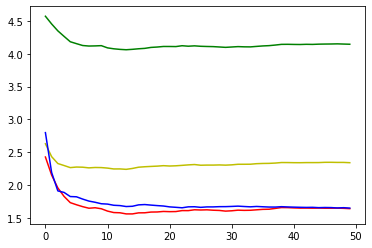

In [57]:
plt.plot([i for i in range(50)], flattened_My[:50], c ='g')
plt.plot([i for i in range(50)], flattened_Awg[:50], c ='y')
plt.plot([i for i in range(50)], flattened_Joined[:50], c ='r')
plt.plot([i for i in range(50)], flattened_T[:50], c ='b')

print(min(flattened_My), min(flattened_Awg), min(flattened_Joined), min(flattened_T))

1.2449899597988732